# Boston Housing Example
This Example was adapted from Deep Learning with Python Chapter 4 Chollet, F. (2021). Deep Learning with Python (2nd ed.). Greenwich, CT, USA: Manning Publications Co.

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### This is an example of a neural net regression analysis problem using the prepackaged Boston Housing dataset from the Keras library.  The Boston Housing dataset has only 506 samples. We will use a deep neural net to predict Boston housing prices from 13 features.  You can read more about the dataset here: https://www.kaggle.com/c/boston-housing

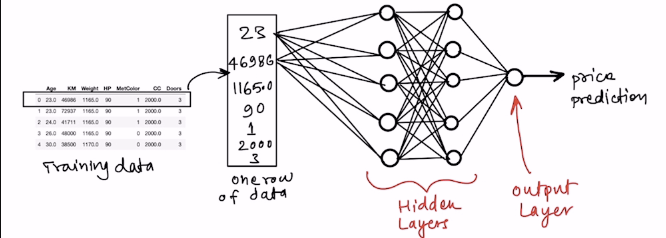

In [ ]:
# Set the seed for reproducibility
import numpy as np
np.random.seed(1)

In [ ]:
# Import the boston housing data set
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
# A total of 506 samples split between train and test data.  Each have 13 features used in predicting Boston House prices
print(train_data.shape)
print(test_data.shape)

In [ ]:
# The targets are Boston housing prices in thousands of dollars
print(train_targets[1:10])

In [ ]:
# The features have very different ranges and values
print(train_data[0:5,:])

In [ ]:
# Since all the features have very different ranges and values it is best to normalize the data.
# We will subtract the mean value from each feature and divide by one standard deviation.
# This will center the data in each feature column around zero with unit standard deviation.
# Note: we *don't* compute a separate mean/std. deviation for the test data -- transformations
# you apply to your test data should only leverage information learned from the training data,
# otherwise you are inadvertently "peeking" at your test data, which can give you a false
# impression of how well your model generalizes.
mean = train_data.mean(axis = 0)
train_data -= mean

std = train_data.std(axis = 0)
train_data /= std

test_data -= mean
test_data /= std

In [ ]:
# Now the features have very similar ranges and values
print(train_data[0:5,:])

In [ ]:
# Here's another way to accomplish the same task, using
# an off-the-shelf preprocessor provided by the
# scikit-learn library
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
# Import libraries
from keras import models
from keras import layers
from keras import backend
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_targets, test_size=0.2, shuffle= True)

In [ ]:
# Build the model. One hidden layer with 64 hidden units. Since it is a regression analysis the output shape will be 1 (linear)
backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1))

In [ ]:
# Compile the model. MSE = mean squared error is a typical loss function for regression.  MAE = mean absolute error, a common regression metric
model.compile(optimizer = 'adam', loss  = 'mse', metrics=['mae'])

In [ ]:
# Fit the model to the data.  I set verbose = 0 so we will not see any output.
history = model.fit(x_train,
                   y_train,
                   epochs = 1000,
                   batch_size=16,
                   validation_data=(x_valid, y_valid),
                   verbose = 0)

In [ ]:
# Use this bit of code to view the History output.
hist = pd.DataFrame(history.history)
print(hist.tail())

In [ ]:
#Plot the loss and MAE vs epochs
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['mae']
val_acc_values = history_dict['val_mae']
epochs = range(1, len(history_dict['mae']) + 1)

In [ ]:
#Plot the loss epochs
plt.plot(epochs, loss_values, 'r', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.ylim(0,20)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Plot MAE vs epochs
plt.plot(epochs, acc_values, 'r', label = 'Training MAE')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation MAE')
plt.ylim(0,5)
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
#Plot MAE vs epochs
plt.plot(epochs, acc_values, 'r', label = 'Training MAE')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation MAE')
plt.ylim(2,3)
plt.xlim(50,200)
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [ ]:
# Apply the model to the test data and view the results.
results = model.evaluate(test_data, test_targets)
print(results)
print(model.metrics_names)

In [ ]:
# It looks like validation loss and mean absolute error increase after about 200 epochs.
# Lets remake the model with only 200 epochs

backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer = 'adam', loss  = 'mse', metrics=['mae'])

history = model.fit(x_train,
                   y_train,
                   epochs = 200,
                   batch_size=16,
                   validation_data=(x_valid, y_valid),
                   verbose = 0)

results = model.evaluate(test_data, test_targets)
print(results)
print(model.metrics_names)

### We will incorporate K-Fold cross validation to help improve our model
Since we have so few data points it makes sence to train and validate on all the data in k-fold batches. We will use `scikit-learn` to do the [k-fold cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html ).

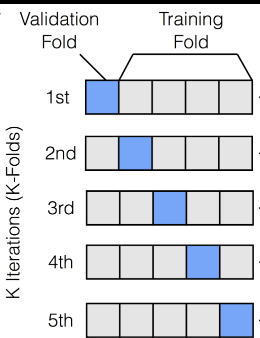

In [ ]:
# This time when we build the model we want to wrap it in a function because
# we will be building a model for each k-fold of our validation steps.
# To make sure we are comparing apples to apples lets use the same parameters
# we used above.

def build_model():
  backend.clear_session()
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer = 'adam', loss  = 'mse', metrics=['mae'])
  return model

In [ ]:
# Now we program in the KFold validation from sklearns
# We will use 4 Kfold steps for validation on the original train data

from sklearn.model_selection import KFold

k = 4 # Number of splits
kf = KFold(n_splits = k, shuffle=True) # Call the KFold function
all_val_mae_scores=[] # Where we will save all of the outputs 
num_epochs = 1000
num_batch = 16
# We have to run a loop and save all the mae scores from each of our 4 
# KFold splits 
for k_train_index, k_val_index in kf.split(train_data, train_targets): 
  model = build_model()
  history = model.fit(train_data[k_train_index], train_targets[k_train_index], 
                      validation_data = (train_data[k_val_index], train_targets[k_val_index]),
                      epochs = num_epochs, batch_size=num_batch, verbose = 0)
  all_val_mae_scores.append(history.history['val_mae'])

In [ ]:
# Look at all the scores
# all_val_mae_scores

In [ ]:
# We need to average each of the 4 KFold mae scores
average_val_mae = [np.mean([x[i] for x in all_val_mae_scores]) for i in range(num_epochs)]

In [ ]:
# Plot the average Val 
plt.plot(range(1, len(average_val_mae) + 1), average_val_mae)
plt.ylim()
plt.xlim()
plt.title('Average Validation MAE from K-Fold CV')
plt.xlabel('Epochs')
plt.ylabel('Average Val MAE')
plt.legend()
plt.show()

In [ ]:
# Lets zoom in on that plot to find the optimal number of epochs to run.
plt.plot(range(1, len(average_val_mae) + 1), average_val_mae)
plt.ylim(2,3)
plt.xlim(50,400)
plt.title('Average Validation MAE from K-Fold CV')
plt.xlabel('Epochs')
plt.ylabel('Average Val MAE')
plt.legend()
plt.show()

In [ ]:
# Rerun the model with the optimal epochs.
k = 4
kf = KFold(n_splits = k)
all_mae_scores=[]
num_epochs = 225
num_batch = 16
for k_train, k_val in kf.split(train_data, train_targets):
  model = build_model()
  history = model.fit(train_data[k_train], train_targets[k_train], 
                      validation_data = (train_data[k_val], train_targets[k_val]),
                      epochs = num_epochs, batch_size=num_batch, verbose = 0)

In [ ]:
# Evaluate our model on the test data.
results = model.evaluate(test_data, test_targets)
print(results)
print(model.metrics_names)